In [1]:
import numpy as np
from scipy.linalg import expm
from numpy.linalg import inv,multi_dot
from scipy.signal import StateSpace, cont2discrete
from scipy.signal import dstep
from matplotlib import pyplot as plt

In [33]:
#Given Parametric values:

Ca= 0.08235       #mol/l ##Measured product concentration
T = 395          #K ##Reactor temperature
qc= 100            #l/min ##Coolant flow rate
q = 100             #l/min ##Process flow rate
Ca0 = 1             #mol/l ##Feed Concentration
T0 = 350.0          #K ##Feed Temperature                                       
T_C0 = 290.0        #K ##Inlet coolant temperature
V = 100             #l ##CSTR volume
hA = 7e5            #cal/(minK) ##Heat transfer term
k0 = 7.2e10         #1/min ##Reaction rate constant 
E_R = 9.98e3        #K ##Activation Energy
delta_H = 2e5       #cal/mol ##Heat of reaction                                 
rho = rho_c = 1e3   #g/l ##Liquid density
Cp = Cp_c = 1       #cal/gk ##Specific heats
delta_t = 0.1       #min ##time step
N = 50                                                                    

###Calculating matrix A, B, C and D.
### First calculating some large constant terms in the second ODE
a1 = (-delta_H*k0)/(rho*Cp)
a2 = (rho_c*Cp_c)/(rho*Cp*V)
a3 = -hA/(Cp*rho)

### So the ODEs for the CSTR system:
dCadt = (q/V)*(Ca0-Ca)-k0*Ca*np.exp(-E_R/T)
dTdt = (q/V)*(T0-T)-(a1*Ca)*np.exp(-E_R/T) + (a2*qc)*(1-(np.exp(a3/qc)))*(T_C0-T)

####Matrix A
A11 = -q/V - k0*np.exp(-E_R/T)
A12 = k0*Ca*np.exp(-E_R/T)*E_R/(T**2) # removed negative
A21 = -a1*np.exp(-E_R/T)
A22 = -q/V + a1*Ca*np.exp(-E_R/T)*E_R/(T**2) - a2*qc*(1-(np.exp(a3/qc))) # removed second term negative
A = np.array([[A11, A12], [A21, A22]])
print(f"Matrix A :\n", A)

####Matrix B
B11 = (Ca0-Ca)/V
B12 = 0
B21 = (T0-T)/V
B22 =  -a2*((qc-a3)*np.exp(a3/qc)-qc)/qc *(T_C0-T)#a2*(1-(np.exp(a3/qc)))*(T_C0-T)
B = np.array([[B11, B12], [B21, B22]])
print(f"Matrix B:\n", B)

####Matrix C
C = np.eye(2)
print(f"Matrix C:\n", C)

####Matrix D
D = np.array([[0, 0], [0, 0]])
print(f"Matrix D:\n", D)

####Calculating phi and gamma
M2 = cont2discrete((A, B, C, D), delta_t) 
print(f"\u03C6 =\n", M2[0])
print(f"\u0393 =\n", M2[1])

Phi = M2[0]
Gamma = M2[1]

###Step response
sysd = (Phi,Gamma,C,D,delta_t)
t_step,y_steps = dstep(sysd,n=51)

y_step = np.array(y_steps)
y_q,y_qc = y_step
y_q_CA,y_q_T = y_q[:,0],y_q[:,1]
y_qc_CA,y_qc_T = y_qc[:,0],y_qc[:,1]

Matrix A :
 [[-1.76652281e+00  4.03761620e-03]
 [ 1.53304561e+02 -2.80661136e+00]]
Matrix B:
 [[ 0.0091765   0.        ]
 [-0.45       -1.04234019]]
Matrix C:
 [[1. 0.]
 [0. 1.]]
Matrix D:
 [[0 0]
 [0 0]]
φ =
 [[8.40578564e-01 3.21709798e-04]
 [1.22150242e+01 7.57706230e-01]]
Γ =
 [[ 8.34158433e-04 -1.81071729e-05]
 [-3.32226523e-02 -9.09739234e-02]]


In [3]:
P=10 #Prediction horizon

M=5 #Control horizon

w=1 #Weight

def DMC(P,M,w,Ca_sp,T_sp):
  #Setpoint
  r_CA=np.zeros((P,1))
  r_T=np.zeros((P,1))                                                           
  r_CA[:] = Ca_sp #mol/L
  r_T[:] = T_sp#5 #K
  r=np.vstack((r_CA, r_T))                                                      

  W=np.eye(2*M)*w                                                               

  N=50   #Model length

  delta_t=0.1 #Sample time
  tf_step=N*delta_t
  t_step=np.linspace(0,tf_step,N+1)

  t_f = 5000 #Total simulation time
  t = np.linspace(0,t_f,round(t_f/delta_t)+1)

  #S_f for output(CA,T) respect to input(q,qc)
  #CA w.r.t q
  S_f_q_CA=np.zeros((P,M))

  for i in range(P):
      for j in range(M):
          if i == j:
              S_f_q_CA[i][j] = y_q_CA[1]
          elif i > j:
              S_f_q_CA[i][j] = y_q_CA[i - j + 1]

  #CA w.r.t qc
  S_f_qc_CA=np.zeros((P,M))

  for i in range(P):
      for j in range(M):
          if i == j:
              S_f_qc_CA[i][j] = y_qc_CA[1]
          elif i > j:
              S_f_qc_CA[i][j] = y_qc_CA[i - j + 1]
    
  #T w.r.t q
  S_f_q_T=np.zeros((P,M))

  for i in range(P):
      for j in range(M):
          if i == j:
              S_f_q_T[i][j] = y_q_T[1]
          elif i > j:
              S_f_q_T[i][j] = y_q_T[i - j + 1]

  #T w.r.t qc
  S_f_qc_T=np.zeros((P,M))

  for i in range(P):
      for j in range(M):
          if i == j:
              S_f_qc_T[i][j] = y_qc_T[1]
          elif i > j:
              S_f_qc_T[i][j] = y_qc_T[i - j + 1]

  #Dynamic matrix
  S_f1=np.hstack((S_f_q_CA, S_f_qc_CA))
  S_f2=np.hstack((S_f_q_T, S_f_qc_T))
  S_f=np.vstack((S_f1, S_f2))

  S_f.shape
  S_past_q_CA=np.zeros((P,N-2))
  #print(S_past_q_CA.shape)
  y_step_aug_q_CA=np.hstack((y_q_CA[1:N],np.zeros((P-1))))
  #print(y_step_aug_q_CA.shape)
  S_past_q_CA[:,0] = y_step_aug_q_CA[1:P+1]
  # s_N = y_step[N]
  for i in range(1,N-2,1):
      S_past_q_CA[:,i] = y_step_aug_q_CA[i+1:i+P+1]

  #CA w.r.t q
  S_past_q_CA=np.zeros((P,N-2))
  y_step_aug_q_CA=np.hstack((y_q_CA[1:N],np.zeros((P-1))))
  S_past_q_CA[:,0] = y_step_aug_q_CA[1:P+1]
  for i in range(0,N-2,1):
    S_past_q_CA[:,i]=y_step_aug_q_CA[i:P+i]

  #CA w.r.t qc
  S_past_qc_CA=np.zeros((P,N-2))
  y_step_aug_qc_CA=np.hstack((y_qc_CA[1:N],np.zeros((P-1))))
  for i in range(0,N-2,1):
    S_past_qc_CA[:,i]=y_step_aug_qc_CA[i+1:P+1+i]

  #T w.r.t q
  S_past_q_T=np.zeros((P,N-2))
  y_step_aug_q_T=np.hstack((y_q_T[1:N],np.zeros((P-1))))
  for i in range(0,N-2,1):
    S_past_q_T[:,i]=y_step_aug_q_T[i+1:P+1+i]

  #T w.r.t qc
  S_past_qc_T=np.zeros((P,N-2))
  y_step_aug_qc_T=np.hstack((y_qc_T[1:N],np.zeros((P-1))))
  for i in range(0,N-2,1):
    S_past_qc_T[:,i]=y_step_aug_qc_T[i+1:P+1+i]

  #Dynamic controller
  S_past1=np.hstack((S_past_q_CA,S_past_qc_CA))
  S_past2=np.hstack((S_past_q_T,S_past_qc_T))
  S_past=np.vstack((S_past1,S_past2))


  #S_N
  s_N_q_CA=y_q_CA[N]
  s_N_qc_CA=y_qc_CA[N]
  s_N_q_T=y_qc_T[N]
  s_N_qc_T=y_qc_T[N]


  #u_past
  u_past_q=np.zeros((N-1,1))#initialize q past inputs 
  u_past_qc=np.zeros((N-1,1))#initialize qc past inputs 
  u_past=np.vstack((u_past_q,u_past_qc))


  d_hat=np.zeros((round(t_f/delta_t)+1,2*P,1))#initialize predicted disturbances
  y_hat=np.zeros((round(t_f/delta_t)+1,2,1))#initialize predicted output for additive disturbance calculation
  error=np.zeros((round(t_f/delta_t)+1,2,1))#initialize error calculation

  u=np.zeros((round(t_f/delta_t)+1,2,1))
  x=np.zeros((round(t_f/delta_t)+1,2,1))
  y=np.zeros((round(t_f/delta_t)+1,2,1))
 

  for k in range(0,round(t_f/delta_t),1):
    #delta_u_past
    delta_u_past_q=u_past_q[0:N-2] - u_past_q[1:N-1]
    delta_u_past_qc=u_past_qc[0:N-2] - u_past_qc[1:N-1]
    delta_u_past=(np.vstack((delta_u_past_q,delta_u_past_qc)))

    #u_p
    u_past_flip_q=np.flip(u_past_q)
    u_p_q=u_past_flip_q[0:P]
    u_past_flip_qc=np.flip(u_past_qc)
    u_p_qc=u_past_flip_qc[0:P]
    u_p=np.vstack((u_p_q,u_p_qc))

    #E
    E=r-S_past@delta_u_past-d_hat[k]
    E[0:P]=E[0:P]-s_N_q_CA*u_p[0:P]-s_N_qc_CA*u_p[P:2*P]
    E[P:2*P]=(E[P:2*P]-s_N_q_T*u_p[0:P]-s_N_qc_T*u_p[P:2*P])


    #delta_u_f (Without constraints)
    delta_u_f=inv(S_f.T@S_f+W)@S_f.T@E


    #loop for updating u
    if(k>0):
      u[k,0]=delta_u_f[0]+u[k-1,0]
      u[k,1]=delta_u_f[M]+u[k-1,1]

      u[k+1,0]=u[k,0]#For plotting purposes
      u[k+1,1]=u[k,1]
    else:
      u[k,0]=delta_u_f[0]
      u[k,1]=delta_u_f[M]

    #Plant equation
    x[k+1]=Phi@x[k]+Gamma@u[k]
    y[k+1]=C@x[k+1]+D@u[k+1]


    #y_hat
    y_hat[k+1,0]=S_f[0]@delta_u_f+S_past[0]@delta_u_past+s_N_q_CA*u_p[0]+s_N_qc_CA*u_p[P]
    y_hat[k+1,1]=S_f[P]@delta_u_f+S_past[P]@delta_u_past+s_N_q_T*u_p[0]+s_N_qc_T*u_p[P]

    #d_hat
    d_hat[k+1,0:P]=np.ones((P,1))*(y[k+1]-y_hat[k+1])[0]
    d_hat[k+1,P:2*P]=np.ones((P,1))*(y[k+1]-y_hat[k+1])[1]

    #update u_past
    u_past_q=np.vstack((u[k,0],u_past_q[0:N-2]))
    u_past_qc=np.vstack((u[k,1],u_past_qc[0:N-2]))

    #error
    error[k+1,0]=r_CA[0,0]-y[k+1,0]
    error[k+1,1]=r_T[0,0]-y[k+1,1]

  CA_new = Ca0 + y[:, 0][-1][0]
  T_new = T + y[:, 1][-1][0]
  q_new = q + u[:, 0][-1][0]
  qc_new = qc + u[:, 1][-1][0]
  """
  print(f'CA SS = {CA_new}')
  print(f'T SS = {T_new}')
  print(f'q SS = {q_new}')
  print(f'qc SS = {qc_new}')
  """
  print("Ca % Error:",(CA_new - Ca - Ca_sp)/(Ca + Ca_sp))                       
  print("T % Error:", (T_new - T - T_sp)/(T + T_sp))
  #print(Ca_sp)
  #print(f'CA SS = {CA_new}')
  SSE=np.sum(np.square(error))

  return t, y, u

t, y, u = DMC(2*P,2*M,w,1,10)


Ca % Error: 0.8478311082368025
T % Error: 0.0


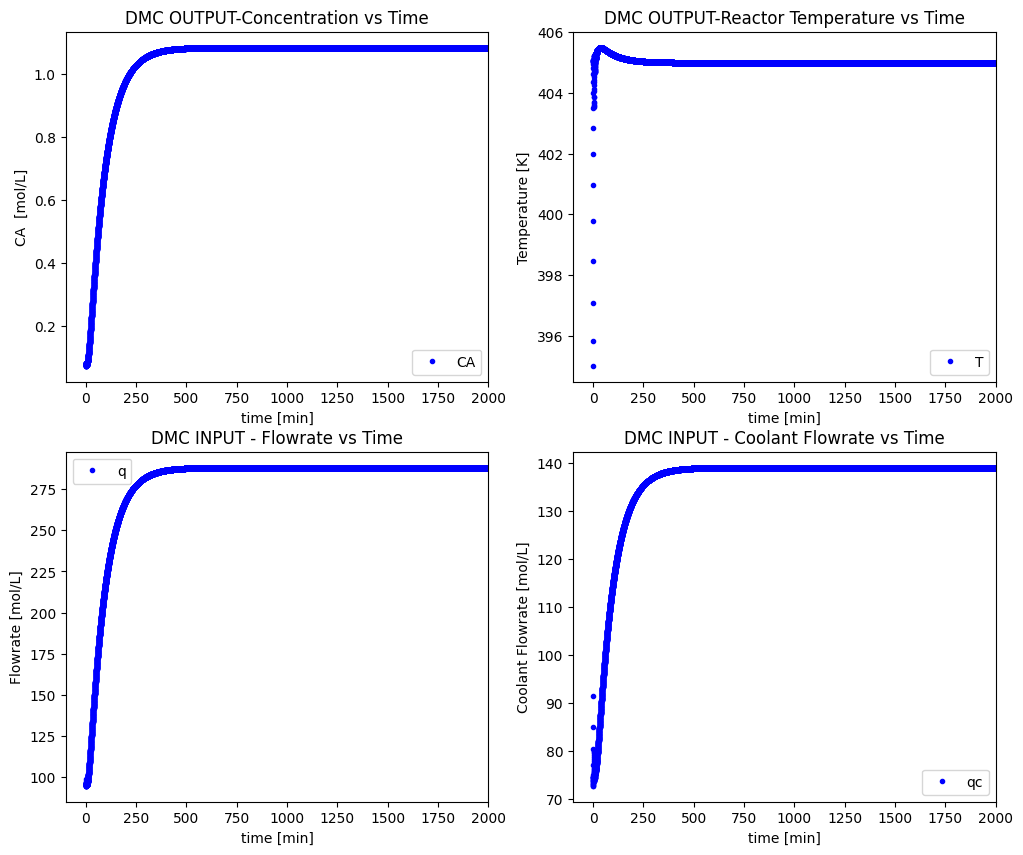

In [35]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.plot(t,(y[:,0]+Ca),'b.',label="CA") 
plt.xlabel("time [min]")
plt.ylabel("CA  [mol/L]")
plt.title('DMC OUTPUT-Concentration vs Time')
plt.xlim([-100,2000])
plt.legend()

plt.subplot(2,2,2)
plt.plot(t,(y[:,1]+T),'b.',label="T")
plt.xlabel("time [min]")
plt.ylabel("Temperature [K]")
plt.xlim([-100,2000])
plt.title('DMC OUTPUT-Reactor Temperature vs Time')
plt.legend()


plt.subplot(2,2,3)
plt.plot(t,(u[:,0]+q),'b.',label="q") 
plt.xlabel("time [min]")
plt.ylabel("Flowrate [mol/L]")
plt.xlim([-100,2000])
plt.title('DMC INPUT - Flowrate vs Time')
plt.legend()

plt.subplot(2,2,4)
plt.plot(t,(u[:,1]+qc),'b.',label="qc") 
plt.xlabel("time [min]")
plt.ylabel("Coolant Flowrate [mol/L]")
plt.xlim([-100,2000])
plt.title('DMC INPUT - Coolant Flowrate vs Time')
plt.legend()
plt.show()


Sensitivity Analysis
===

##Tuning with P##

In [5]:
M=5
W=1
output_CA=[]
output_T=[]
output_Q=[]
output_Qc=[]


for P in [5,8,10]:
  t, y, u = DMC(2*P,2*M,W,1,10)
  output_CA.append(y[:,0])
  output_T.append(y[:,1])
  output_Q.append(u[:,0])
  output_Qc.append(u[:,1])
  

Ca % Error: 0.8478188183118975
T % Error: 4.008043078225276e-09
Ca % Error: 0.8478311082367237
T % Error: 0.0
Ca % Error: 0.8478311082368025
T % Error: 0.0


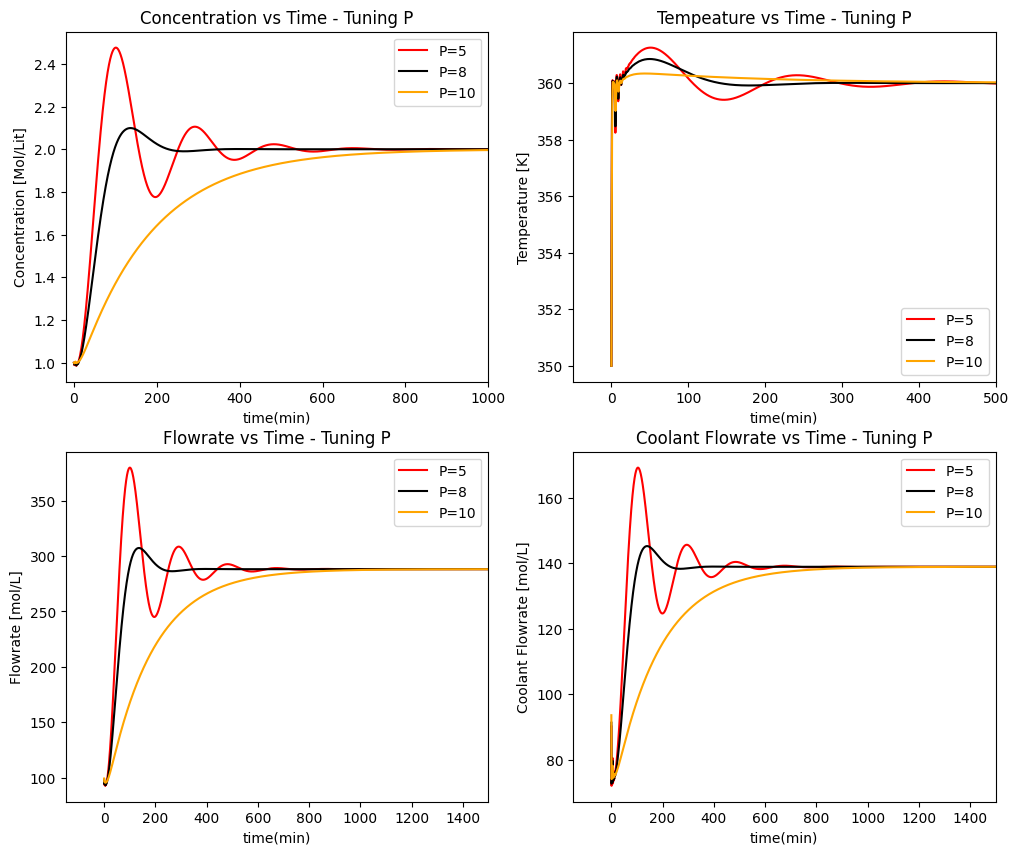

In [23]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(t,output_CA[0]+Ca0,label='P=5',color='red')
plt.plot(t,output_CA[1]+Ca0,label='P=8',color='black')
plt.plot(t,output_CA[2]+Ca0,label='P=10',color='orange')
plt.xlim([-20,1000])
plt.title('Concentration vs Time - Tuning P')
plt.ylabel('Concentration [Mol/Lit]')
plt.xlabel('time(min)')
plt.legend();

plt.subplot(2,2,2)
plt.plot(t,output_T[0]+T0,label='P=5',color='red')
plt.plot(t,output_T[1]+T0,label='P=8',color='black')
plt.plot(t,output_T[2]+T0,label='P=10',color='orange')
plt.xlim([-50,500])
plt.title('Tempeature vs Time - Tuning P')
plt.ylabel('Temperature [K]')
plt.xlabel('time(min)')
plt.legend();

plt.subplot(2,2,3)
plt.plot(t,output_Q[0]+q,label='P=5',color='red')
plt.plot(t,output_Q[1]+q,label='P=8',color='black')
plt.plot(t,output_Q[2]+q,label='P=10',color='orange')
plt.xlim([-150,1500])
plt.title('Flowrate vs Time - Tuning P')
plt.ylabel('Flowrate [mol/L]')
plt.xlabel('time(min)')
plt.legend();

plt.subplot(2,2,4)
plt.plot(t,output_Qc[0]+qc,label='P=5',color='red')
plt.plot(t,output_Qc[1]+qc,label='P=8',color='black')
plt.plot(t,output_Qc[2]+qc,label='P=10',color='orange')
plt.xlim([-150,1500])
plt.title('Coolant Flowrate vs Time - Tuning P')
plt.ylabel('Coolant Flowrate [mol/L]')
plt.xlabel('time(min)')
plt.legend();


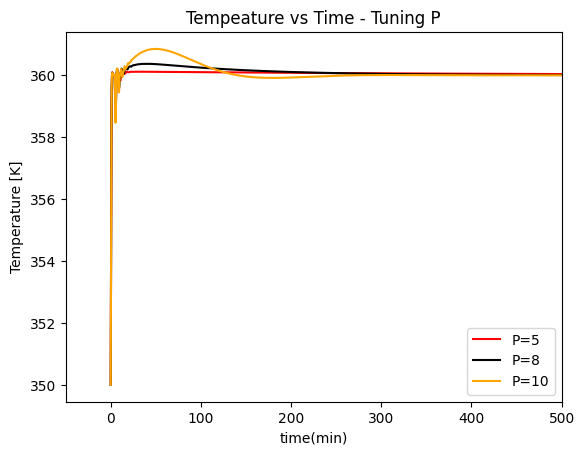

In [7]:
plt.plot(t,output_T[0]+T0,label='P=5',color='red')
plt.plot(t,output_T[1]+T0,label='P=8',color='black')
plt.plot(t,output_T[2]+T0,label='P=10',color='orange')
plt.xlim([-50,500])
plt.title('Tempeature vs Time - Tuning P')
plt.ylabel('Temperature [K]')
plt.xlabel('time(min)')
plt.legend();

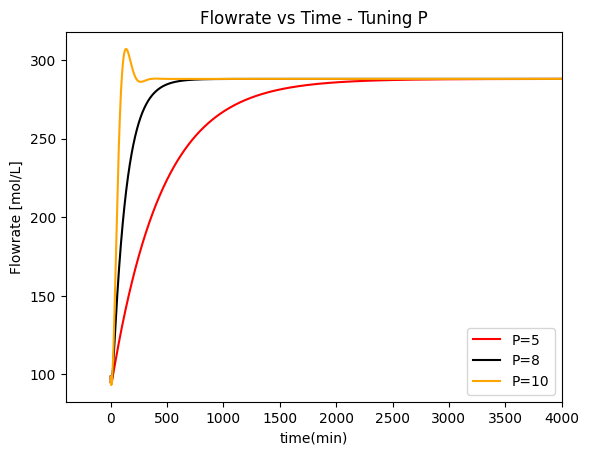

In [8]:
plt.plot(t,output_Q[0]+q,label='P=5',color='red')
plt.plot(t,output_Q[1]+q,label='P=8',color='black')
plt.plot(t,output_Q[2]+q,label='P=10',color='orange')
plt.xlim([-400,4000])
plt.title('Flowrate vs Time - Tuning P')
plt.ylabel('Flowrate [mol/L]')
plt.xlabel('time(min)')
plt.legend();


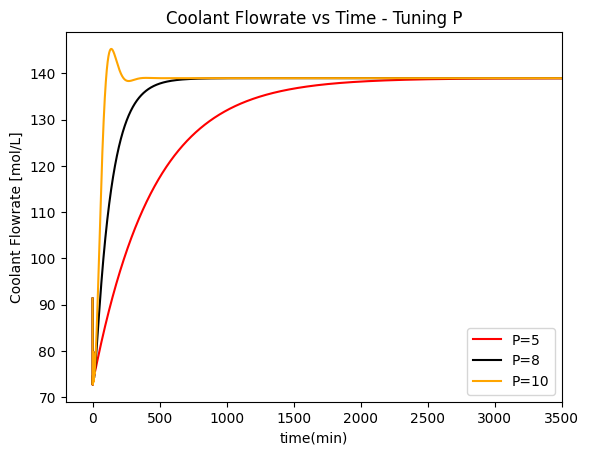

In [9]:
plt.plot(t,output_Qc[0]+qc,label='P=5',color='red')
plt.plot(t,output_Qc[1]+qc,label='P=8',color='black')
plt.plot(t,output_Qc[2]+qc,label='P=10',color='orange')
plt.xlim([-200,3500])
plt.title('Coolant Flowrate vs Time - Tuning P')
plt.ylabel('Coolant Flowrate [mol/L]')
plt.xlabel('time(min)')
plt.legend();




**Tuning M**

In [10]:

P=10
M=5
output_CA=[]
output_T=[]
output_Q=[]
output_Qc=[]


for W in [0.75,1,2]:
  t, y, u = DMC(2*P,2*M,W,1,10)
  output_CA.append(y[:,0])
  output_T.append(y[:,1])
  output_Q.append(u[:,0])
  output_Qc.append(u[:,1])
  

Ca % Error: 0.8478311082366076
T % Error: 0.0
Ca % Error: 0.8478311082368025
T % Error: 0.0
Ca % Error: 0.8478311082362814
T % Error: 8.421247238638225e-16


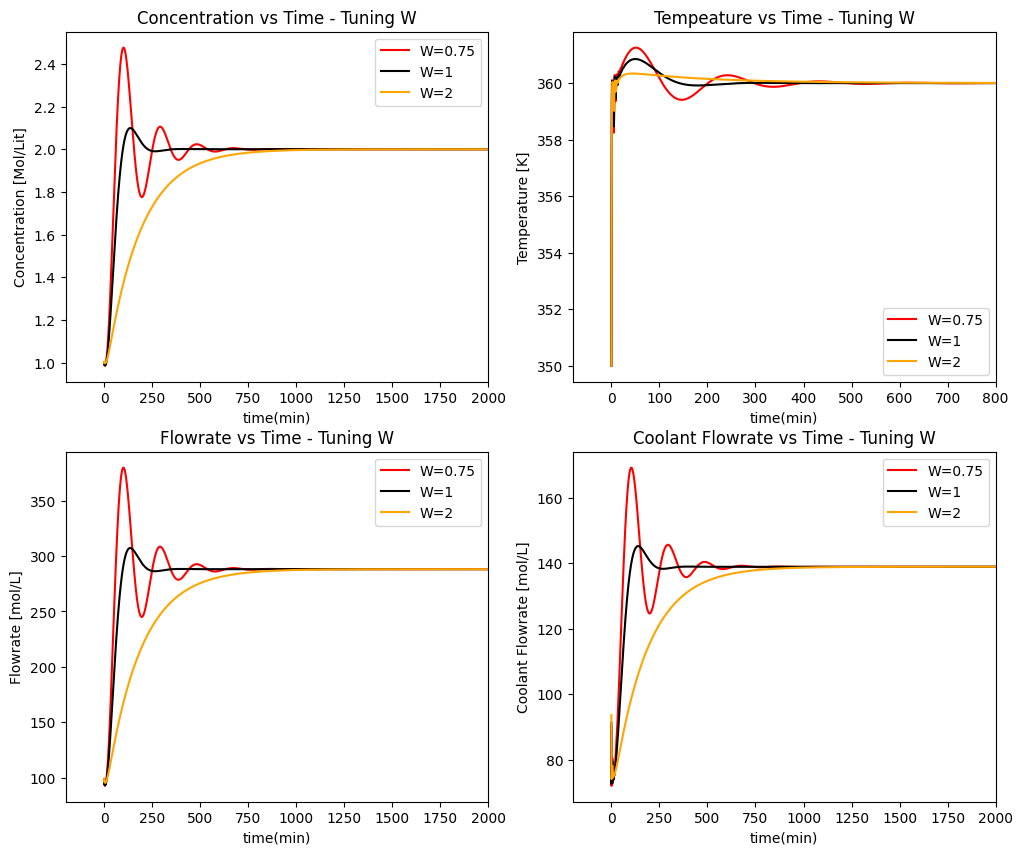

In [17]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.plot(t,output_CA[0]+Ca0,label='W=0.75',color='red')
plt.plot(t,output_CA[1]+Ca0,label='W=1',color='black')
plt.plot(t,output_CA[2]+Ca0,label='W=2',color='orange')
plt.xlim([-200,2000])
plt.title('Concentration vs Time - Tuning W')
plt.ylabel('Concentration [Mol/Lit]')
plt.xlabel('time(min)')
plt.legend()
plt.subplot(2,2,2)
plt.plot(t,output_T[0]+T0,label='W=0.75',color='red')
plt.plot(t,output_T[1]+T0,label='W=1',color='black')
plt.plot(t,output_T[2]+T0,label='W=2',color='orange')
plt.xlim([-80,800])
plt.title('Tempeature vs Time - Tuning W')
plt.ylabel('Temperature [K]')
plt.xlabel('time(min)')
plt.legend();

plt.subplot(2,2,3)
plt.plot(t,output_Q[0]+q,label='W=0.75',color='red')                            
plt.plot(t,output_Q[1]+q,label='W=1',color='black')
plt.plot(t,output_Q[2]+q,label='W=2',color='orange')                            
plt.xlim([-200,2000])
plt.title('Flowrate vs Time - Tuning W')
plt.ylabel('Flowrate [mol/L]')                                                  
plt.xlabel('time(min)')
plt.legend();

plt.subplot(2,2,4)
plt.plot(t,output_Qc[0]+qc,label='W=0.75',color='red')                          
plt.plot(t,output_Qc[1]+qc,label='W=1',color='black')                           
plt.plot(t,output_Qc[2]+qc,label='W=2',color='orange')                          
plt.xlim([-200,2000])
plt.title('Coolant Flowrate vs Time - Tuning W')
plt.ylabel('Coolant Flowrate [mol/L]')                                          
plt.xlabel('time(min)')
plt.legend();


In [26]:

P=10
W=1
output_CA=[]
output_T=[]
output_Q=[]
output_Qc=[]


for M in [5,10,20]:
  t, y, u = DMC(2*P,2*M,W,1,10)
  output_CA.append(y[:,0])
  output_T.append(y[:,1])
  output_Q.append(u[:,0])
  output_Qc.append(u[:,1])

Ca % Error: 0.8478311082368025
T % Error: 0.0
Ca % Error: 0.8478311082367336
T % Error: 0.0
Ca % Error: 0.8478311082367266
T % Error: 0.0


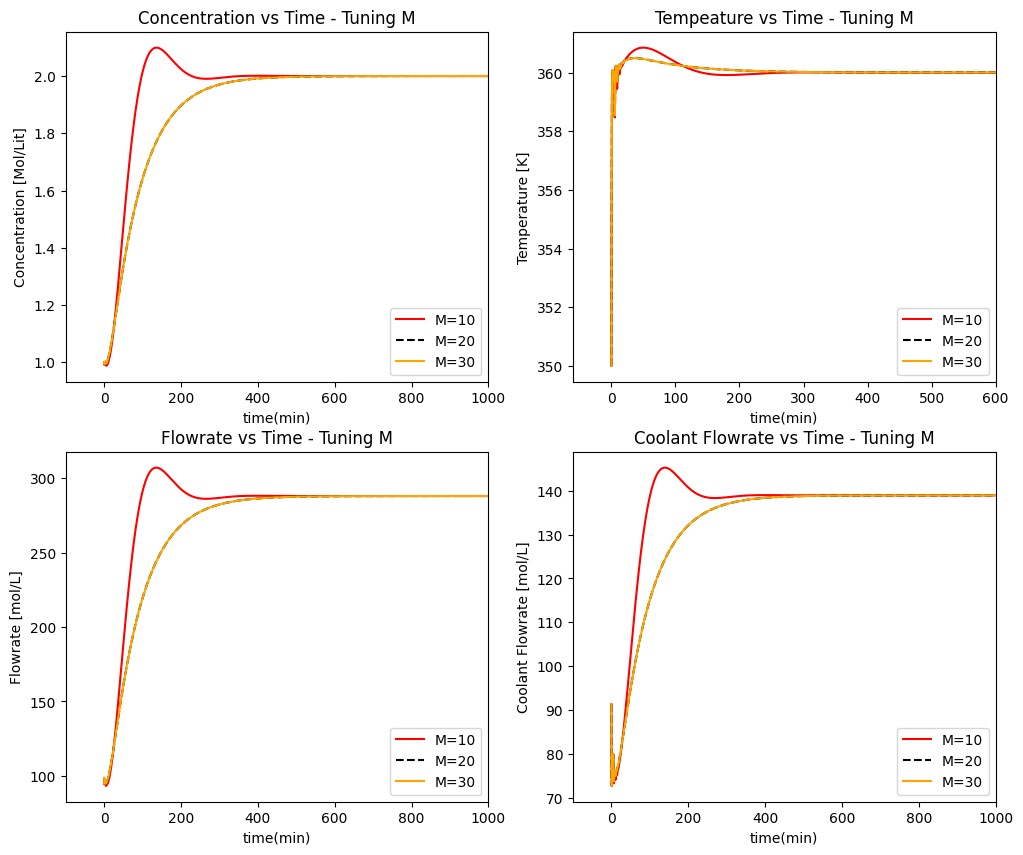

In [31]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.plot(t,output_CA[0]+Ca0,label='M=10',color='red')
plt.plot(t,output_CA[1]+Ca0,'--',label='M=20',color='black')
plt.plot(t,output_CA[2]+Ca0,label='M=30',color='orange')
plt.xlim([-100,1000])
plt.title('Concentration vs Time - Tuning M')
plt.ylabel('Concentration [Mol/Lit]')
plt.xlabel('time(min)')
plt.legend()
plt.subplot(2,2,2)
plt.plot(t,output_T[0]+T0,label='M=10',color='red')
plt.plot(t,output_T[1]+T0,'--',label='M=20',color='black')
plt.plot(t,output_T[2]+T0,label='M=30',color='orange')
plt.xlim([-60,600])
plt.title('Tempeature vs Time - Tuning M')
plt.ylabel('Temperature [K]')
plt.xlabel('time(min)')
plt.legend();

plt.subplot(2,2,3)
plt.plot(t,output_Q[0]+q,label='M=10',color='red')                            
plt.plot(t,output_Q[1]+q,'--',label='M=20',color='black')
plt.plot(t,output_Q[2]+q,label='M=30',color='orange')                            
plt.xlim([-100,1000])
plt.title('Flowrate vs Time - Tuning M')
plt.ylabel('Flowrate [mol/L]')                                                  
plt.xlabel('time(min)')
plt.legend();

plt.subplot(2,2,4)
plt.plot(t,output_Qc[0]+qc,label='M=10',color='red')                          
plt.plot(t,output_Qc[1]+qc,'--',label='M=20',color='black')                           
plt.plot(t,output_Qc[2]+qc,label='M=30',color='orange')                          
plt.xlim([-100,1000])
plt.title('Coolant Flowrate vs Time - Tuning M')
plt.ylabel('Coolant Flowrate [mol/L]')                                          
plt.xlabel('time(min)')
plt.legend();